In [195]:
!pip install torch
!pip install numpy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [196]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

In [197]:
def relu(x):
    return np.maximum(0, x)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def swish(x):
    return x * 1 / (1 + np.exp(-x))


def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))


def softplus(x, beta=1):
    return (1 / beta) * np.log(1 + np.exp(beta * x))


def mish(x, beta=1):
    return x * np.tanh(softplus(x, beta))

In [198]:
# Implementation of spike function for PyTorch custom gradient
class SpikeFunction(autograd.Function):
    @staticmethod
    def forward(ctx, v_scaled):
        z_ = torch.where(v_scaled > 0, torch.ones_like(v_scaled), torch.zeros_like(v_scaled))
        ctx.save_for_backward(v_scaled)
        return z_

    @staticmethod
    def backward(ctx, grad_output):
        v_scaled, = ctx.saved_tensors
        dz_dv_scaled = torch.maximum(1 - torch.abs(v_scaled), torch.tensor(0.0, device=v_scaled.device))
        dE_dv_scaled = grad_output * dz_dv_scaled
        return dE_dv_scaled

# Call spike function for PyTorch
def spike_function(v_scaled):
    return SpikeFunction.apply(v_scaled)

# FS class definition
class FS(nn.Module):
    def __init__(self, num_params):
        super(FS, self).__init__()

        if num_params == 4:
            h = torch.tensor([4.4682, 4.2097, 0.5166, 0.4746])
            d = torch.tensor([4.2236, 4.1465, 1.3406, 1.4113])
            T = torch.tensor([3.4595, 3.2402, 0.2901, 1.2908])
        elif num_params == 8:
            h = torch.tensor([1.4939, 1.6136, 4.7730, 2.4916, 1.4080, 0.9018, 1.0605, 0.3997])
            d = torch.tensor([0.4433, 1.3525, 4.7553, 2.4729, 1.3782, 0.8179, 0.5103, 0.2444])
            T = torch.tensor([-0.9802,  0.2283,  4.0217,  1.5428,  0.3840, -0.4479, -1.0518, -1.8225])
        elif num_params == 12:
            h = torch.tensor([1.1507,  1.9843,  4.1558,  2.2380,  1.1598,  1.1832,  0.6838,  0.9808, 0.9599,  1.5397, -2.4526,  1.5903])
            d = torch.tensor([0.7290, 1.9051, 4.1505, 2.2302, 1.1365, 0.9365, 0.4517, 0.2054, 0.1066, 0.0487, 0.1452, 0.1571])
            T = torch.tensor([0.5358,  2.1906,  4.5437,  2.4850,  1.3502,  0.6904, -0.0415, -1.2596, -2.2509, -3.8104, -3.8233, -1.2061])
        elif num_params == 16:
            h = torch.tensor([0.8390, 1.2366, 3.2619, 1.9236, 0.7046, 2.2526, 1.2453, 1.0133, 0.7192,0.7911, 0.8382, 0.6877, 0.6364, 1.0113, 1.7649, 0.7065])
            d = torch.tensor([0.7098, 0.0542, 3.2631, 1.9232, 0.1635, 2.2172, 1.2149, 0.9410, 0.6259,0.5588, 0.4810, 0.3097, 0.2454, 0.1651, 0.7377, 0.0692])
            T = torch.tensor([1.6926, -3.4559,  5.9155,  4.1239, -2.5486,  1.9903,  0.7669,  0.1584,-0.4227, -0.8991, -1.4492, -1.9575, -2.3678, -2.8489,  0.3304, -3.6109])

        self.h = nn.Parameter(h + torch.normal(0, 0.1, size=h.size()))
        self.d = nn.Parameter(d + torch.normal(0, 0.1, size=d.size()))
        self.T = nn.Parameter(T + torch.normal(0, 0.1, size=T.size()))

    def forward(self, x):
        v = x.clone()

        # Initialize temporary output for FS spike neural network
        temp_out = torch.zeros_like(v)

        # Implement FS spike neural network
        for t in range(len(self.T)):
            #v_scaled = (v - self.T[t]) / (torch.abs(v) + 1)
            v_scaled = v - self.T[t]
            z = spike_function(v_scaled)
            temp_out += z * self.d[t]
            v = v - z * self.h[t]

        return temp_out

# Softplus

K=4

Epoch 1/20000, Loss: 0.13686822354793549
Epoch 1001/20000, Loss: 0.124730683863163
Epoch 2001/20000, Loss: 0.12474390864372253
Epoch 3001/20000, Loss: 0.12474683672189713
Epoch 4001/20000, Loss: 0.12474820017814636
Epoch 5001/20000, Loss: 0.12475049495697021
Epoch 6001/20000, Loss: 0.12474140524864197
Epoch 7001/20000, Loss: 0.12475208938121796
Epoch 8001/20000, Loss: 0.12474843859672546
Epoch 9001/20000, Loss: 0.12474342435598373
Epoch 10001/20000, Loss: 0.1247415840625763
Epoch 11001/20000, Loss: 0.12474513798952103
Epoch 12001/20000, Loss: 0.12474609166383743
Epoch 13001/20000, Loss: 0.12475146353244781
Epoch 14001/20000, Loss: 0.12474982440471649
Epoch 15001/20000, Loss: 0.1247454509139061
Epoch 16001/20000, Loss: 0.1247449442744255
Epoch 17001/20000, Loss: 0.12474943697452545
Epoch 18001/20000, Loss: 0.12474517524242401
Epoch 19001/20000, Loss: 0.12474291026592255
Loss values: [0.13686822354793549, 0.12428470700979233, 0.1245696172118187, 0.12468130141496658, 0.1247183233499527, 0

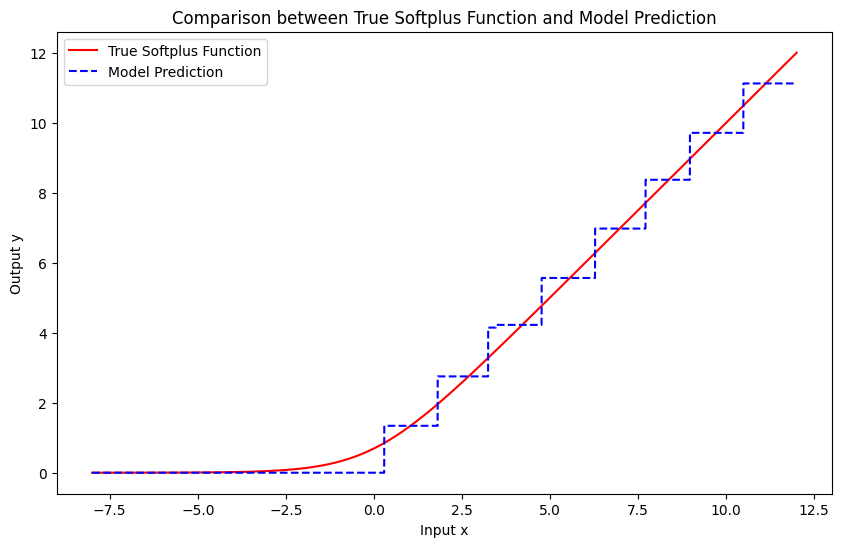

In [199]:
# Instantiate model and initial setup
num_params = 4  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

k=8

In [200]:
# Instantiate model and initial setup
num_params = 8  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

Epoch 1/20000, Loss: 0.04750986397266388
Epoch 1001/20000, Loss: 0.005755600519478321
Epoch 2001/20000, Loss: 0.005788150709122419
Epoch 3001/20000, Loss: 0.005802694242447615
Epoch 4001/20000, Loss: 0.005808552727103233
Epoch 5001/20000, Loss: 0.005836769938468933
Epoch 6001/20000, Loss: 0.005825698841363192
Epoch 7001/20000, Loss: 0.005818987265229225
Epoch 8001/20000, Loss: 0.005817465018481016
Epoch 9001/20000, Loss: 0.005816957913339138


k=12

Epoch 1/20000, Loss: 0.025133024901151657
Epoch 1001/20000, Loss: 0.0020438204519450665
Epoch 2001/20000, Loss: 0.0020820798818022013
Epoch 3001/20000, Loss: 0.0020362436771392822
Epoch 4001/20000, Loss: 0.001956127816811204
Epoch 5001/20000, Loss: 0.001835955074056983
Epoch 6001/20000, Loss: 0.0016029358375817537
Epoch 7001/20000, Loss: 0.0015310832532122731
Epoch 8001/20000, Loss: 0.001512741087935865
Epoch 9001/20000, Loss: 0.0014577897964045405
Epoch 10001/20000, Loss: 0.0014616658445447683
Epoch 11001/20000, Loss: 0.0014745957450941205
Epoch 12001/20000, Loss: 0.0014520788099616766
Epoch 13001/20000, Loss: 0.0014753470895811915
Epoch 14001/20000, Loss: 0.001483983127400279
Epoch 15001/20000, Loss: 0.0014850974548608065
Epoch 16001/20000, Loss: 0.0015166043303906918
Epoch 17001/20000, Loss: 0.0015271389856934547
Epoch 18001/20000, Loss: 0.0015219217166304588
Epoch 19001/20000, Loss: 0.0015202694339677691
Loss values: [0.025133024901151657, 0.0025185691192746162, 0.00219949241727590

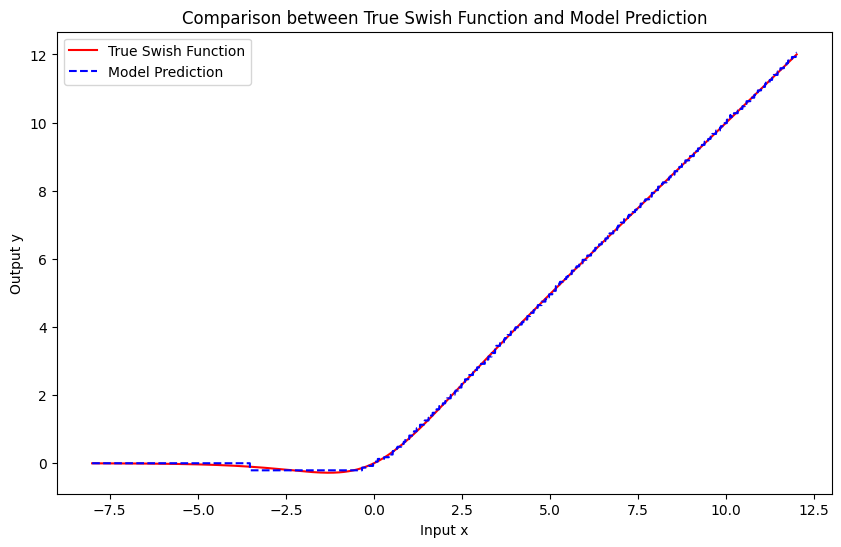

In [ ]:
# Instantiate model and initial setup
num_params = 12  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()

K=16

Epoch 1/20000, Loss: 0.07762262970209122
Epoch 1001/20000, Loss: 0.0016506942920386791
Epoch 2001/20000, Loss: 0.0012184550287202
Epoch 3001/20000, Loss: 0.0011306538945063949
Epoch 4001/20000, Loss: 0.0010998934740200639
Epoch 5001/20000, Loss: 0.0010803114855661988
Epoch 6001/20000, Loss: 0.0010804637568071485
Epoch 7001/20000, Loss: 0.0010785858612507582
Epoch 8001/20000, Loss: 0.0010284829186275601
Epoch 9001/20000, Loss: 0.0010365640046074986
Epoch 10001/20000, Loss: 0.0010369031224399805
Epoch 11001/20000, Loss: 0.0010379842715337873
Epoch 12001/20000, Loss: 0.0010338341817259789
Epoch 13001/20000, Loss: 0.0010366210481151938
Epoch 14001/20000, Loss: 0.001034353394061327
Epoch 15001/20000, Loss: 0.0010305942269042134
Epoch 16001/20000, Loss: 0.0010190234752371907
Epoch 17001/20000, Loss: 0.0010174013441428542
Epoch 18001/20000, Loss: 0.00108362827450037
Epoch 19001/20000, Loss: 0.0010886420495808125
Loss values: [0.07762262970209122, 0.003598578739911318, 0.0026488816365599632, 0

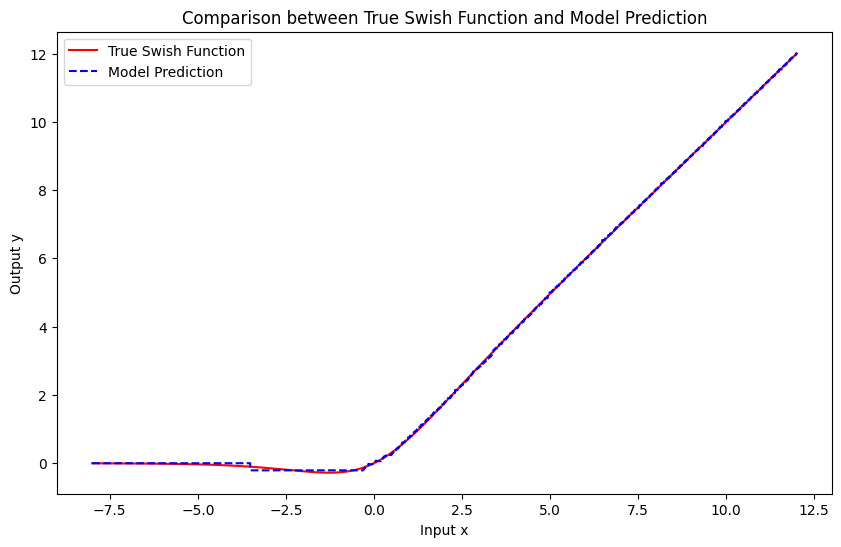

In [ ]:
# Instantiate model and initial setup
num_params = 16  # Select arbitrary number of parameters
model = FS(num_params)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training data
x_train = torch.linspace(-8, 12, steps=100000).unsqueeze(1)

# x_train = torch.cat((
#     torch.linspace(-8, -5, steps=5000),
#     torch.linspace(-5, 0, steps=60000),
#     torch.linspace(0, 12, steps=35000)
# )).unsqueeze(1)

y_train = softplus(x_train)  # Target value

torch.autograd.set_detect_anomaly(True)

# Training loop
loss_values = []

epochs = 20000
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    y_pred = model(x_train)  # Forward pass, including v_reg and z_reg calculations
    loss = criterion(y_pred, y_train)  # Remove `.squeeze()` call
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
       print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    if epoch % 200 == 0:
       loss_values.append(loss.item())

# Print final loss
print("Loss values:", loss_values)
print(f'Final Loss: {loss.item()}')
print(f'Final h: {model.h.data}')
print(f'Final d: {model.d.data}')
print(f'Final T: {model.T.data}')

# Calculate model predictions
with torch.no_grad():  # No gradient computation needed
    y_pred = model(x_train).squeeze()

# True function values
y_true = softplus(x_train).squeeze()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_true.numpy(), label='True Softplus Function', color='r')
plt.plot(x_train.numpy(), y_pred.numpy(), label='Model Prediction', linestyle='--', color='b')
plt.title('Comparison between True Softplus Function and Model Prediction')
plt.xlabel('Input x')
plt.ylabel('Output y')
plt.legend()

plt.show()